#### Dogs vs cats classification with Pytorch

In [1]:
#References: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py
#https://github.com/svishnu88/DLwithPyTorch/blob/master/Chapter3/Image%20Classification%20Dogs%20and%20Cats.ipynb
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import copy
import os

%matplotlib inline
#plt.ion() interacrive mode

#### Prepare data

In [3]:
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
valid_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_data = ImageFolder('/home/karen/fastai/courses/dl1/data/dogscats/cats_and_dogs/train', train_transform)
valid_data = ImageFolder('/home/karen/fastai/courses/dl1/data/dogscats/cats_and_dogs/validation', valid_transform)

In [4]:
print(train_data.class_to_idx, train_data.classes)

{'cats': 0, 'dogs': 1} ['cats', 'dogs']


In [5]:
if torch.cuda.is_available():
    is_cuda = True

In [7]:
#To display images after converting to tensor in ImageFolder
def imshow(img):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

In [8]:
train_data_gen = DataLoader(train_data, shuffle=True,batch_size=32)
valid_data_gen = DataLoader(valid_data, shuffle=False,batch_size=32)


In [ ]:
dataset_sizes = {'train':len(train_data_gen.dataset), 'valid':len(valid_data_gen.dataset)}
dataloaders = {'train':train_data_gen,'valid':valid_data_gen}

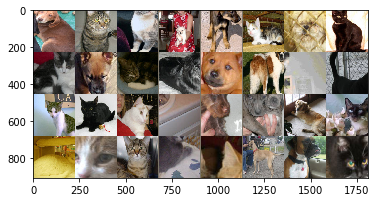

In [11]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)
imshow(out)

In [12]:
print(dataset_sizes)

{'train': 16000, 'valid': 5000}


In [13]:
model_ft = models.resnet34(pretrained=True)
num_fts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_fts, 2)

In [14]:
model_ft = model_ft.cuda()

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_ft.parameters(), lr=0.001)

#Decay learning rate by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [18]:
from torch.autograd import Variable
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    start = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('-'*12)
        print('Epoch {}/{}'. format(epoch, num_epochs - 1))
        print('-'*12)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss= 0.0
            running_corrects = 0
            
            for data in dataloaders[phase]:
                inputs, labels = data
                if(torch.cuda.is_available()):
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _,preds = torch.max(outputs.data,1)
                loss = criterion(outputs,labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss/dataset_sizes[phase]
            epoch_acc = running_corrects/dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

                    

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

------------
Epoch 0/19
------------


/home/karen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [ ]:
#To visualize model predictions
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)